In [32]:
!export HF_HOME="/workspaces/udop/i-Code-Doc/.hf_cache"
!export HF_DATASETS_CACHE="/workspaces/udop/i-Code-Doc/.hf_cache"

In [33]:
import os
import datasets
import requests
import logging
import torch
from typing import Optional
from datasets import load_dataset  # type: ignore
from PIL.TiffImagePlugin import TiffImageFile
from io import BytesIO
import sys
sys.path.append('/workspaces/udop/i-Code-Doc')
from core.models import UdopDualForConditionalGeneration, UdopUnimodelForConditionalGeneration, UdopConfig, UdopTokenizer

In [34]:
file_dir = "/workspaces/udop/i-Code-Doc/core/datasets"
cache_dir = os.sep.join(file_dir.split(os.sep)[:-2]) + os.sep + '.hf_cache'
ocr_url = "http://nginx:80/ocr"

In [35]:
dataset = load_dataset("rvl_cdip", cache_dir=cache_dir)

Found cached dataset rvl_cdip (/workspaces/udop/i-Code-Doc/.hf_cache/rvl_cdip/default/1.0.0/ea410993ed3f5b9744d8616ffbaad5f70a75a21a4233626dd07b3de31d381e53)
100%|██████████| 3/3 [00:00<00:00, 61.35it/s]


In [36]:
tokenizer = UdopTokenizer.from_pretrained(
        "/workspaces/udop/i-Code-Doc/model/hf",
        cache_dir="/workspaces/udop/i-Code-Doc/.hf_cache/transformers",
        use_fast=True
    )

['<extra_id_0>', '<extra_id_1>', '<extra_id_2>', '<extra_id_3>', '<extra_id_4>', '<extra_id_5>', '<extra_id_6>', '<extra_id_7>', '<extra_id_8>', '<extra_id_9>', '<extra_id_10>', '<extra_id_11>', '<extra_id_12>', '<extra_id_13>', '<extra_id_14>', '<extra_id_15>', '<extra_id_16>', '<extra_id_17>', '<extra_id_18>', '<extra_id_19>', '<extra_id_20>', '<extra_id_21>', '<extra_id_22>', '<extra_id_23>', '<extra_id_24>', '<extra_id_25>', '<extra_id_26>', '<extra_id_27>', '<extra_id_28>', '<extra_id_29>', '<extra_id_30>', '<extra_id_31>', '<extra_id_32>', '<extra_id_33>', '<extra_id_34>', '<extra_id_35>', '<extra_id_36>', '<extra_id_37>', '<extra_id_38>', '<extra_id_39>', '<extra_id_40>', '<extra_id_41>', '<extra_id_42>', '<extra_id_43>', '<extra_id_44>', '<extra_id_45>', '<extra_id_46>', '<extra_id_47>', '<extra_id_48>', '<extra_id_49>', '<extra_id_50>', '<extra_id_51>', '<extra_id_52>', '<extra_id_53>', '<extra_id_54>', '<extra_id_55>', '<extra_id_56>', '<extra_id_57>', '<extra_id_58>', '<extr

In [37]:
from datasets import DatasetDict
slice_data: DatasetDict = DatasetDict({key: dataset[key].select(range(10)) for key in dataset.keys()})
slice_data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 10
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 10
    })
})

{'image': <PIL.TiffImagePlugin.TiffImageFile image mode=L size=762x1000 at 0x7F3B157EF490>, 'label': 11}
(762, 1000)


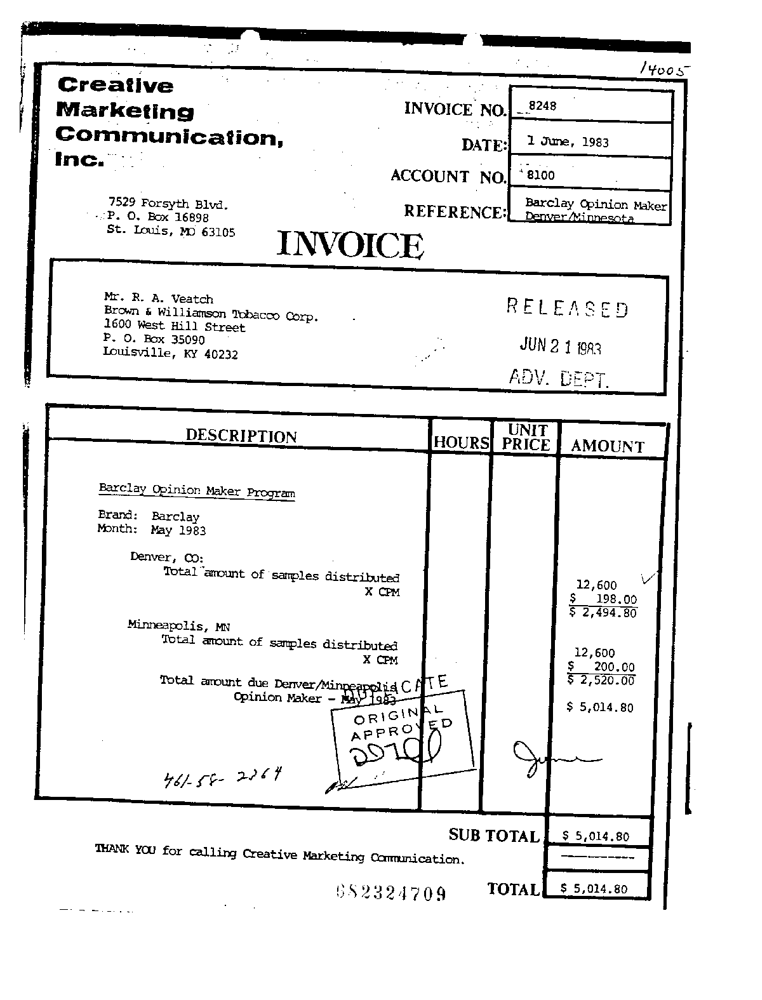

In [38]:
# Get first example
assert type(dataset) is datasets.dataset_dict.DatasetDict, f"Dataset is not of type Dataset, but {type(dataset)}"
print(dataset["train"][0])

# Get first image size
image: TiffImageFile = dataset["train"][0]["image"]
print(image.size)

# Print the image in the notebook
image.show()

In [39]:
def request_ocr(url: str, image: TiffImageFile, lang='en', format='TIFF'):
    # Transform image to send in request
    byte_io = BytesIO()
    image.save(byte_io, format=format)
    byte_io.seek(0)
    
    response = requests.post(url, files={"image": byte_io}, data={"lang": "en"})
    return response.json()["result"]

In [40]:
result = request_ocr(ocr_url, dataset["train"][0]['image']) # type: ignore
result

[[[[[639.0, 58.0], [691.0, 63.0], [689.0, 81.0], [637.0, 75.0]],
   ['14005', 0.9867923855781555]],
  [[[56.0, 72.0], [175.0, 75.0], [175.0, 97.0], [56.0, 94.0]],
   ['Creative', 0.9770511388778687]],
  [[[55.0, 97.0], [195.0, 103.0], [194.0, 124.0], [53.0, 117.0]],
   ['Marketing', 0.9872258305549622]],
  [[[402.0, 98.0], [506.0, 101.0], [506.0, 119.0], [402.0, 115.0]],
   ['INVOICE NO', 0.9573636054992676]],
  [[[526.0, 95.0], [559.0, 98.0], [558.0, 114.0], [525.0, 111.0]],
   ['8248', 0.9936767220497131]],
  [[[55.0, 122.0], [284.0, 129.0], [283.0, 150.0], [55.0, 142.0]],
   ['Communication,', 0.9680752754211426]],
  [[[459.0, 135.0], [509.0, 135.0], [509.0, 154.0], [459.0, 154.0]],
   ['DATE:', 0.9900647401809692]],
  [[[524.0, 132.0], [611.0, 134.0], [611.0, 150.0], [524.0, 148.0]],
   ['1 J,1983', 0.8331589698791504]],
  [[[52.0, 149.0], [107.0, 151.0], [106.0, 169.0], [51.0, 166.0]],
   ['Inc.', 0.8791302442550659]],
  [[[390.0, 166.0], [507.0, 168.0], [507.0, 186.0], [389.0, 18

In [41]:
for res in result:
    for line in res:
        text = line[1][0]
        top_left = line[0][0]
        bottom_right = line[0][2]
        print(text, top_left, bottom_right)


14005 [639.0, 58.0] [689.0, 81.0]
Creative [56.0, 72.0] [175.0, 97.0]
Marketing [55.0, 97.0] [194.0, 124.0]
INVOICE NO [402.0, 98.0] [506.0, 119.0]
8248 [526.0, 95.0] [558.0, 114.0]
Communication, [55.0, 122.0] [283.0, 150.0]
DATE: [459.0, 135.0] [509.0, 154.0]
1 J,1983 [524.0, 132.0] [611.0, 150.0]
Inc. [52.0, 149.0] [106.0, 169.0]
ACCOUNT NO. [390.0, 166.0] [507.0, 186.0]
8100 [517.0, 165.0] [556.0, 183.0]
7529 Forsyth Blvd. [107.0, 191.0] [228.0, 215.0]
REFERENCE: [402.0, 201.0] [510.0, 221.0]
Barclay Opinion Maker [524.0, 194.0] [666.0, 214.0]
P.O.Bcx16898 [91.0, 207.0] [211.0, 225.0]
DerverNinnesot [524.0, 209.0] [631.0, 223.0]
St.LisM 63105 [104.0, 221.0] [236.0, 240.0]
INVOICE [275.0, 228.0] [423.0, 260.0]
Mr.R.A.Veatch [103.0, 288.0] [215.0, 306.0]
Brown & williamson Tobacco Corp. [103.0, 302.0] [318.0, 324.0]
RELEASED [506.0, 295.0] [628.0, 319.0]
1600 West Hill Street [103.0, 314.0] [247.0, 335.0]
P.O.BcX 35090 [102.0, 329.0] [207.0, 347.0]
JUN 2 1 t9A3 [520.0, 333.0] [603.0,

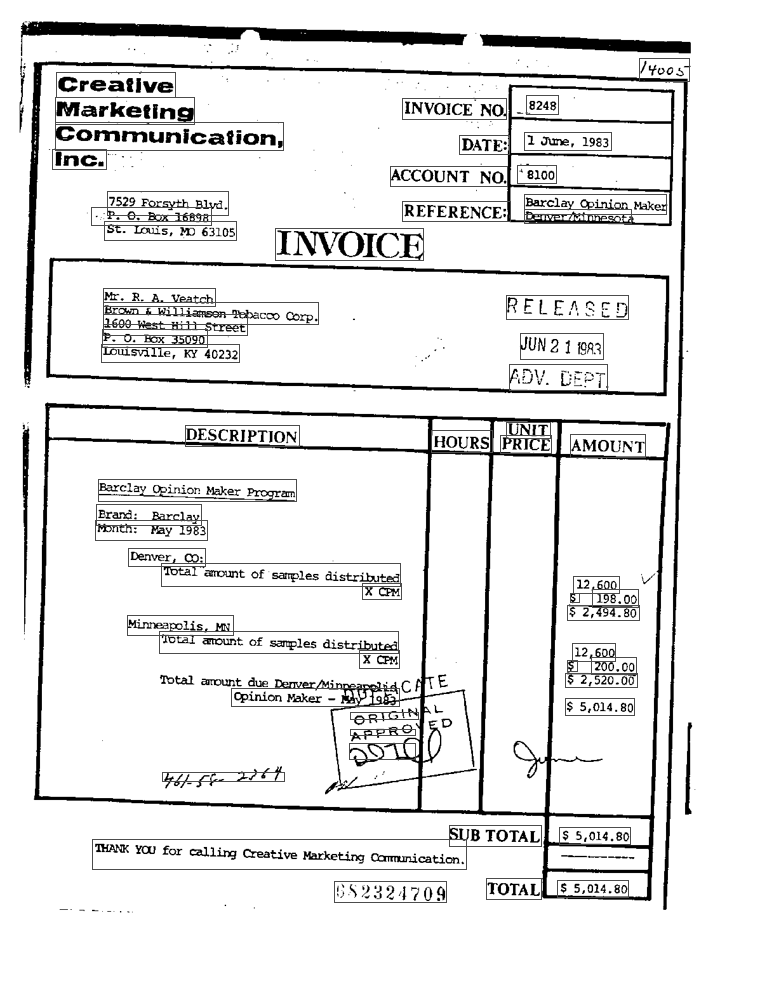

In [42]:
# Print the bboxes in the image in the notebook
from PIL import ImageDraw

image = dataset["train"][0]["image"]
draw = ImageDraw.Draw(image)
for res in result:
    for line in res:
        top_left = line[0][0]
        bottom_right = line[0][2]
        draw.rectangle(xy=(top_left[0], top_left[1], bottom_right[0], bottom_right[1]), outline="red")
image.show()

# Normalize images

In [43]:
import torchvision.transforms as T
from torchvision.transforms import functional as F


class Normalize(object):
    def __init__(self, mean, std, format='rgb'):
        self.mean = mean
        self.std = std
        self.format = format.lower()

    def __call__(self, image):
        if 'bgr' in self.format:
            image = image[[2, 1, 0]]
        if '255' in self.format:
            image = image * 255
        if image.size(0) == 1:
            image = image.repeat(3, 1, 1)
        image = F.normalize(image, mean=self.mean, std=self.std)
        return image

def img_trans_torchvision(image, image_size=224):
    trans = T.Compose([
            T.Resize([image_size,image_size]),
            T.ToTensor(),
            Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )])

    image = trans(image)  # copy to make it writeable
    return image

In [44]:
image_size = 224
n_image = img_trans_torchvision(image, image_size)
n_image

tensor([[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         ...,
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
         [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

        [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         ...,
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
         [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

        [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
         [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.

# Normalize text

In [45]:
def normalText(t):
    if type(t) is float:
        if t == int(t):
            t = int(t)
    t = str(t)
    return t.strip()

# All together

In [46]:


def process_ocr(url, image: TiffImageFile, tokenizer, image_size: int, lang='en') -> Optional[tuple]:
    """
    Process TiffImageFile with OCR, tokenize the text and for every token create a bounding box.
    :param image: TiffImageFile. Image to process.
    :param tokenizer: Tokenizer. Tokenizer to use.
    :param image_size: int. Size of the image.
    :return: tuple. list_tokens, list_bboxes, image, page_size
    """
    text_list, bbox_list = [], []
    page_size = image.size

    result = request_ocr(url, image, lang)
    if result is None:
        return None
    
    # Normalize text and bbox
    for res in result:
        for line in res:
            text = line[1][0]
            n_text = normalText(text)
            if text == '':
                continue
            sub_tokens = tokenizer.tokenize(n_text)

            min_x = line[0][0][0]
            min_y = line[0][0][1]
            max_x = line[0][2][0]
            max_y = line[0][2][1]

            for sub_token in sub_tokens:
                text_list.append(sub_token)
                bbox_list.append([min_x, min_y, max_x, max_y])

    assert len(text_list) == len(bbox_list)

    # Normalize image
    n_image = img_trans_torchvision(image, image_size)

    return text_list, bbox_list, n_image, page_size

In [47]:
result = process_ocr(ocr_url, dataset["train"][0]['image'], tokenizer, image_size)
result

(['▁140',
  '05',
  '▁Creative',
  '▁Marketing',
  '▁IN',
  'VO',
  'ICE',
  '▁NO',
  '▁',
  '82',
  '48',
  '▁Communication',
  ',',
  '▁D',
  'ATE',
  ':',
  '▁1',
  '▁J',
  ',',
  '19',
  '83',
  '▁Inc',
  '.',
  '▁AC',
  'CO',
  'UNT',
  '▁NO',
  '.',
  '▁8',
  '100',
  '▁75',
  '29',
  '▁For',
  's',
  'y',
  'th',
  '▁Blvd',
  '.',
  '▁RE',
  'FER',
  'ENCE',
  ':',
  '▁Bar',
  'cla',
  'y',
  '▁O',
  'pinion',
  '▁Maker',
  '▁P',
  '.',
  'O',
  '.',
  'B',
  'c',
  'x',
  '168',
  '98',
  '▁Der',
  'ver',
  'N',
  'inne',
  's',
  'o',
  't',
  '▁St',
  '.',
  'L',
  'is',
  'M',
  '▁',
  '63',
  '105',
  '▁IN',
  'VO',
  'ICE',
  '▁Mr',
  '.',
  'R',
  '.',
  'A',
  '.',
  'V',
  'e',
  'atch',
  '▁Brown',
  '▁',
  '&',
  '▁will',
  'i',
  'am',
  'son',
  '▁To',
  'b',
  'acco',
  '▁Corp',
  '.',
  '▁R',
  'ELE',
  'ASE',
  'D',
  '▁1600',
  '▁West',
  '▁Hill',
  '▁Street',
  '▁P',
  '.',
  'O',
  '.',
  'B',
  'c',
  'X',
  '▁350',
  '90',
  '▁J',
  'UN',
  '▁2',
  '▁1',
  '

In [48]:
labels = tokenizer.encode([dataset["train"][0]["label"]], add_special_tokens=False)
type(labels)

list

# Builder

In [58]:
def get_visual_bbox(image_size=224):
    image_feature_pool_shape = [image_size//16, image_size//16]
    visual_bbox_x = (torch.arange(
        0,
        1.0 * (image_feature_pool_shape[1] + 1),
        1.0,
    ) / image_feature_pool_shape[1])
    visual_bbox_y = (torch.arange(
        0,
        1.0 * (image_feature_pool_shape[0] + 1),
        1.0,
    ) / image_feature_pool_shape[0])
    visual_bbox_input = torch.stack(
        [
            visual_bbox_x[:-1].repeat(
                image_feature_pool_shape[0], 1),
            visual_bbox_y[:-1].repeat(
                image_feature_pool_shape[1], 1).transpose(
                    0, 1),
            visual_bbox_x[1:].repeat(
                image_feature_pool_shape[0], 1),
            visual_bbox_y[1:].repeat(
                image_feature_pool_shape[1], 1).transpose(
                    0, 1),
        ],
        dim=-1,
    ).view(-1, 4)
    return visual_bbox_input

def process_ocr(url, image: TiffImageFile, tokenizer, lang='en') -> Optional[tuple]:
    """
    Process TiffImageFile with OCR, tokenize the text and for every token create a bounding box.
    :param image: TiffImageFile. Image to process.
    :param tokenizer: Tokenizer. Tokenizer to use.
    :param image_size: int. Size of the image.
    :return: tuple. list_tokens, list_bboxes, image, page_size
    """
    text_list, bbox_list = [], []
    page_size = image.size

    try:
        result = request_ocr(url, image, lang)
    except Exception as e:
        print(f"OCR failed for {url}: {e}")
        return None
    
    # Normalize text and bbox
    for res in result:
        for line in res:
            text = line[1][0]
            n_text = normalText(text)
            if text == '':
                continue
            sub_tokens = tokenizer.tokenize(n_text)

            min_x = line[0][0][0]
            min_y = line[0][0][1]
            max_x = line[0][2][0]
            max_y = line[0][2][1]

            for sub_token in sub_tokens:
                text_list.append(sub_token)
                bbox_list.append([min_x, min_y, max_x, max_y])

    assert len(text_list) == len(bbox_list)

    return text_list, bbox_list, page_size

class HfRvlCdipDatasetBuilder:

    def __init__(self, data_args, tokenizer, num_proc=1):
        file_dir = "/workspaces/udop/i-Code-Doc/core/datasets"
        cache_dir = os.sep.join(file_dir.split(os.sep)[:-2]) + os.sep + '.hf_cache'
        
        self.ocr_url = "http://nginx:80/ocr"
        self.tokenizer = tokenizer
        self.max_seq_length = data_args.max_seq_length
        self.image_size = data_args.image_size
        self.num_proc = num_proc
        
        # Load dataset
        dataset: datasets.DatasetDict = load_dataset("rvl_cdip", cache_dir=cache_dir) # type: ignore
        self.dataset: DatasetDict = DatasetDict({key: dataset[key].select(range(2)) for key in dataset.keys()})
        
        assert type(self.dataset) is datasets.dataset_dict.DatasetDict, f"Dataset is not of type Dataset, but {type(self.dataset)}"
        
        # Print size of dataset
        print(f"Train size: {len(self.dataset['train'])}")
        print(f"Validation size: {len(self.dataset['validation'])}")
        print(f"Test size: {len(self.dataset['test'])}")

    def build_dataset(self):
        print("Building dataset")
        
        print("Filtering out None images and labels...")
        filter_nones = lambda example: example["image"] is not None and example["label"] is not None
        dataset = self.dataset.filter(filter_nones, num_proc=self.num_proc)
        # Example: {'image': TiffImageFile, 'label': int}
        print(dataset['train'][0].keys())

        print("Processing OCR...")
        def read_image(example):
            result = process_ocr(self.ocr_url, example['image'], self.tokenizer)
            if result is None:
                return None
            text_list, bbox_list, page_size = result
            return {
                "text_list": text_list,
                "bbox_list": bbox_list,
                "page_size": page_size
            }
        dataset = dataset.map(read_image, num_proc=self.num_proc)
        # Example: {'image': TiffImageFile, 'label': int, 
        #   'text_list': list, 'bbox_list': list, 'page_size': (width, height)}
        print(dataset['train'][0].keys())
        
        print("Processing images...")
        process_image = lambda example: {
            "image": img_trans_torchvision(example['image'], self.image_size)
        }
        dataset = dataset.map(process_image, num_proc=self.num_proc)
        # Example: {'image': TiffImageFile, 'label': int,
        #   'text_list': list, 'bbox_list': list, 'page_size': (width, height)}
        print(dataset['train'][0].keys())

        print("Normalizing bounding boxes...")
        def normalize_bboxes(example):
            new_bboxes = []
            width, height = example['page_size']
            for bbox in example['bbox_list']:
                new_bbox = [bbox[0] / width, bbox[1] / height, bbox[2] / width, bbox[3] / height]
                new_bboxes.append(new_bbox)
            return {
                "bbox_list": new_bboxes,
            }
        dataset = dataset.map(normalize_bboxes, num_proc=self.num_proc)
        # Example: {'image': TiffImageFile, 'label': int,
        #   'text_list': list, 'bbox_list': list, 'page_size': (width, height)}
        print(dataset['train'][0].keys())
        
        print("Adding visual bounding boxes...")
        add_visual_bboxes = lambda _: {"visual_seg_data": get_visual_bbox(self.image_size)}
        dataset = dataset.map(add_visual_bboxes, num_proc=self.num_proc)
        # Example: {'image': TiffImageFile, 'label': int,
        #   'text_list': list, 'bbox_list': list, 'page_size': (width, height),
        #   'visual_seg_data': torch.Tensor}
        print(dataset['train'][0].keys())
        
        print("Convert tokens to ids...")
        tokens_to_ids = lambda example: {
                "token_list": self.tokenizer.convert_tokens_to_ids(example['text_list']),
            }
        dataset = dataset.map(tokens_to_ids, num_proc=self.num_proc)
        # Example: {'image': TiffImageFile, 'label': int,
        #   'text_list': list, 'bbox_list': list, 'page_size': (width, height),
        #   'visual_seg_data': torch.Tensor, 'token_list': list}
        print(dataset['train'][0].keys())
        
        print("Convert to seq2seq...")
        def convert_seq_to_seq(example):
            prompt_text = 'document classification.'
            prompt_ids =  self.tokenizer.encode(prompt_text, add_special_tokens=False)
            input_ids = prompt_ids + example['token_list']  # To add prompt to input ids
            bbox_list = [[0,0,0,0]] * len(prompt_ids) + example['bbox_list']  # To add prompt with empty bbox
            print(f"input_ids: {self.tokenizer.decode(input_ids)}")
            seq_labels = self.tokenizer.encode([example["label"]], add_special_tokens=True) # To add EOS token
            print(f"seq_labels: {self.tokenizer.decode(seq_labels)}")
            
            attention_mask = [1] * len(input_ids)
            decoder_attention_mask = [1] * len(seq_labels)
            
            return {
                "input_ids": input_ids,
                "bbox_list": bbox_list,
                "seq_labels": seq_labels,
                "attention_mask": attention_mask,
                "decoder_attention_mask": decoder_attention_mask,
            }
        dataset = dataset.map(convert_seq_to_seq, num_proc=self.num_proc)
        # Example: {'image': TiffImageFile, 'label': int,
        #   'text_list': list, 'bbox_list': list, 'page_size': (width, height),
        #   'visual_seg_data': torch.Tensor, 'token_list': list, 'prompt': int,
        #   'seq_labels': list, 'input_ids': list, 'attention_mask': list, 
        #   'decoder_attention_mask': list}
        print(dataset['train'][0].keys())

        # TODO: Add char segmentation for image reconstruction
        add_char = lambda _: {"char_list": []}

        print("Converting to tensors...")
        def convert_to_tensors(example):
            bbox_input = torch.tensor(example['bbox_list'], dtype=torch.float)
            labels = torch.tensor(example['seq_labels'], dtype=torch.long)
            input_ids = torch.tensor(example['input_ids'], dtype=torch.long)
            attention_mask = torch.tensor(example['attention_mask'], dtype=torch.long)
            decoder_attention_mask = torch.tensor(example['decoder_attention_mask'], dtype=torch.long)
            assert len(bbox_input) == len(input_ids)
            assert len(bbox_input.size()) == 2
            
            return {
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "labels": labels,
                "seg_data": bbox_input,
                "visual_seg_data": example['visual_seg_data'],
                "decoder_attention_mask": decoder_attention_mask,
                "image": example['seq_labels'],
                # 'char_ids': char_ids,
                # 'char_seg_data': char_bbox_input
            }
        return dataset.map(convert_to_tensors, num_proc=self.num_proc, remove_columns=dataset['train'].column_names)


In [59]:
from collections import namedtuple

DataArgs = namedtuple('DataArgs', ['max_seq_length', 'image_size'])
data_args = DataArgs(max_seq_length=512, image_size=224)

new_dataset = HfRvlCdipDatasetBuilder(data_args, tokenizer).build_dataset()

Found cached dataset rvl_cdip (/workspaces/udop/i-Code-Doc/.hf_cache/rvl_cdip/default/1.0.0/ea410993ed3f5b9744d8616ffbaad5f70a75a21a4233626dd07b3de31d381e53)
100%|██████████| 3/3 [00:00<00:00, 91.83it/s]
Loading cached processed dataset at /workspaces/udop/i-Code-Doc/.hf_cache/rvl_cdip/default/1.0.0/ea410993ed3f5b9744d8616ffbaad5f70a75a21a4233626dd07b3de31d381e53/cache-5159c3ffce1360aa.arrow
Loading cached processed dataset at /workspaces/udop/i-Code-Doc/.hf_cache/rvl_cdip/default/1.0.0/ea410993ed3f5b9744d8616ffbaad5f70a75a21a4233626dd07b3de31d381e53/cache-0c8e0fb2ba8cba14.arrow
Loading cached processed dataset at /workspaces/udop/i-Code-Doc/.hf_cache/rvl_cdip/default/1.0.0/ea410993ed3f5b9744d8616ffbaad5f70a75a21a4233626dd07b3de31d381e53/cache-65b8a3705faabee7.arrow


Train size: 2
Validation size: 2
Test size: 2
Building dataset
Filtering out None images and labels...
dict_keys(['image', 'label'])
Processing OCR...


100%|██████████| 2/2 [00:14<00:00,  7.43s/ex]


dict_keys(['image', 'label', 'text_list', 'bbox_list', 'page_size'])
Processing images...


100%|██████████| 2/2 [00:00<00:00, 130.22ex/s]


dict_keys(['image', 'label', 'text_list', 'bbox_list', 'page_size'])
Normalizing bounding boxes...


100%|██████████| 2/2 [00:00<00:00, 670.50ex/s]

dict_keys(['image', 'label', 'text_list', 'bbox_list', 'page_size'])
Adding visual bounding boxes...



100%|██████████| 2/2 [00:00<00:00, 1200.60ex/s]


dict_keys(['image', 'label', 'text_list', 'bbox_list', 'page_size', 'visual_seg_data'])
Convert tokens to ids...


100%|██████████| 2/2 [00:00<00:00, 489.42ex/s]


dict_keys(['image', 'label', 'text_list', 'bbox_list', 'page_size', 'visual_seg_data', 'token_list'])
Convert to seq2seq...


100%|██████████| 2/2 [00:00<00:00,  7.30ex/s]

input_ids: document classification. 14005 Creative Marketing INVOICE NO 8248 Communication, DATE: 1 J,1983 Inc. ACCOUNT NO. 8100 7529 Forsyth Blvd. REFERENCE: Barclay Opinion Maker P.O.Bcx16898 DerverNinnesot St.LisM 63105 INVOICE Mr.R.A.Veatch Brown & williamson Tobacco Corp. RELEASED 1600 West Hill Street P.O.BcX 35090 JUN 2 1 t9A3 Louisville, KY 40232 ADV.DEPT DESCRIPTION HOURS UNIT PRICE AMOUNT Barclay Opinion Maker Program Erand:Barclay Month: May 1983 Denver Total'amount of sanples distributed X CPM 12,600 S 198.00 $ 2,494.80 Minneapolis MN Total arount of sanples distributed X CPM 12,600 S 200.00 $2,520.00 pinion Maker -ia $5,014.80 ORIGIN APPRO 201 461-58-2764 SUB TOTAL $5,014.80 THANK YOU for calling Creative Marketing Conmnication. 6S2324709 TOTAL $_5,014.80
seq_labels: and</s>
input_ids: document classification. Lorilarf Iesponae Fa411,1952 Table l Darby Model Mocified Model Nicotine half- Nicotine half-/ lifel0 min.; 1ife40mi.; cotininehalf- Cotinine half- Assumed At. -life


  0%|          | 0/2 [00:00<?, ?ex/s]/opt/conda/lib/python3.8/site-packages/transformers/models/t5/tokenization_t5.py:219: UserWarning: This sequence already has </s>. In future versions this behavior may lead to duplicated eos tokens being added.
  warnings.warn(
100%|██████████| 2/2 [00:00<00:00,  9.34ex/s]

input_ids: document classification. 5_95.pptHHM/URO PRIORITY Review of the Biological Activity of Nitric Oxide 2050963039
seq_labels: .</s>
input_ids: document classification. NOV-17970840FrCARNOLDPQRTER DC 2029425989 T-525P.C1/03cb-398 ARNOLD & PORTER ANH Thurman Arnold Buiiding 555 i2th Street,N.w. Washington, D.C.20004 Telephone:(202 942-5000 Telex: 892733 ARFOPO WSH TELEFAX202) 942-5999 MULTI-ADDRESS TELEFAX TRANSMISSION SHEET We Are Sending Pages (Including This Cover Sheet) DATE: November 16.1997 Voice TO: Name/Company Telefax Number Contact Number l. William L. Allinder 816-391-5598 816-474-6550 2.Thomas J. Frederick 332-558-5700 313-558-5600 3. John Mulderig 212-907-5796 212-880-3056 609-663-7861 609-663-6705 4.L.NunleyIII/BOtero (804344-8822/8833804788-8679 FROM: Leslie Whartor PRIVILEGED AND CONPIDRNTIAL information intended only for the use of the addressee(e) namad above. If the reader of this message is not the intended recipient or the employee or agent responsible for de


100%|██████████| 2/2 [00:00<00:00, 13.21ex/s]


input_ids: document classification. PHILIPMORRISU.S.A. INTER-OFFICECORRESPONDENCE RICHMOND VIRGINIA To: Salaried Delta Personnel Date: February 20, 1989 From: Ann Ganzert and Becky Kanipe Subject: Smoking Panel at the Delta Assembly Center We are seeking volunteers to participate on the smoking panel at the Assembly Center. As the hourly employees will not be on board for a few months, we will be dependent on salaried personnel to make the panel a success. Both smokers and non-smokers are welcome! We do not have specific details regarding the panel at this time, but we can provide some general information to assist you in making your decision. Panel schedules will be flexible to allow sufficient time for smoking and evaluation without impacting your other responsibilities. Each panelist will be requested to complete a monadic test at least once a day. Depending on the number of panelists we may have to ask you to complete multiple smokings in one day. The ballot will be short, consisti

100%|██████████| 2/2 [00:00<00:00, 451.39ex/s]


In [60]:
new_dataset['test'][0]

{'image': [5, 1],
 'visual_seg_data': [[0.0, 0.0, 0.0714285746216774, 0.0714285746216774],
  [0.0714285746216774, 0.0, 0.1428571492433548, 0.0714285746216774],
  [0.1428571492433548, 0.0, 0.2142857164144516, 0.0714285746216774],
  [0.2142857164144516, 0.0, 0.2857142984867096, 0.0714285746216774],
  [0.2857142984867096, 0.0, 0.3571428656578064, 0.0714285746216774],
  [0.3571428656578064, 0.0, 0.4285714328289032, 0.0714285746216774],
  [0.4285714328289032, 0.0, 0.5, 0.0714285746216774],
  [0.5, 0.0, 0.5714285969734192, 0.0714285746216774],
  [0.5714285969734192, 0.0, 0.6428571343421936, 0.0714285746216774],
  [0.6428571343421936, 0.0, 0.7142857313156128, 0.0714285746216774],
  [0.7142857313156128, 0.0, 0.7857142686843872, 0.0714285746216774],
  [0.7857142686843872, 0.0, 0.8571428656578064, 0.0714285746216774],
  [0.8571428656578064, 0.0, 0.9285714030265808, 0.0714285746216774],
  [0.9285714030265808, 0.0, 1.0, 0.0714285746216774],
  [0.0, 0.0714285746216774, 0.0714285746216774, 0.1428571